In [ ]:
import argparse
import os
import sys
import shutil
import random
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from transformers import GPT2TokenizerFast, BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
cs461dir = '/content/drive/My Drive/Colab Notebooks/CS461/'

file_paths = ['fake.test.txt', 'fake.train.txt', 'fake.valid.txt', 'real.test.txt', 'real.train.txt', 'real.valid.txt']
if any(not os.path.exists(filepath) for filepath in file_paths):
  !cp -r "{cs461dir}"* /content/
  print("Files imported")

model_path = "./model_weights"
os.makedirs(model_path, exist_ok=True)

def read_file(filename, opt):
    bios = []
    curr_bio = []
    in_bio = False

    with open(filename, 'r') as f:
      for line in f:
        if '<start_bio>' in line:
          in_bio = True
          curr_bio = []
        elif '<end_bio>' in line:
          in_bio = False
          text = " ".join(curr_bio).strip()
          tokens = opt.tokenizer.encode(text, truncation=True, max_length = opt.max_seqlen)
          bios.append(tokens)
        else:
          if in_bio:
            curr_bio.append(line)
    return bios

class FakeRealDataset(Dataset):
    def __init__(self, real_data, fake_data):
      #real is 0, fake is 1
      self.samples = []
      for seq in real_data:
          self.samples.append((seq, 0))
      for seq in fake_data:
          self.samples.append((seq, 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def beautify_data(batch):
    token_lists, labels = zip(*batch)
    max_len = max(len(t) for t in token_lists)

    padded = []
    for tokens in token_lists:
        padded_seq = tokens + [0]*(max_len - len(tokens))
        padded.append(padded_seq)

    tokens_tensor = torch.tensor(padded, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return tokens_tensor, labels_tensor

Mounted at /content/drive
Files imported


In [ ]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x.int())

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=4096, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return self.dropout(x)

class Norm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        return self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias

def attention_dot_product(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    if dropout is not None:
        scores = dropout(scores)
    return torch.matmul(scores, v)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)
        k = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)
        v = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1,2)

        if mask is not None:
          mask = mask.expand(-1, self.num_heads, -1, -1)
        scores = attention_dot_product(q, k, v, self.d_k, mask=mask, dropout=self.dropout)
        attn_output = scores.transpose(1,2).contiguous().view(batch_size, seq_len, d_model)

        return self.out(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=512, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads, dropout)
        self.norm1 = Norm(d_model)
        self.ff = FeedForward(d_model, ff_dim, dropout)
        self.norm2 = Norm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=6, ff_dim=512, dropout=0.1):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.positional_encoder = PositionalEncoder(d_model, dropout=dropout)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, 2)

    def forward(self, x, mask=None):
        x = self.embed(x)
        x = self.positional_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = x[:, 0, :]
        return self.classifier(x)

In [ ]:
def train(model, opt):
  print("training model...")
  model.to(opt.device)
  optimizer = opt.optimizer
  criterion = nn.CrossEntropyLoss()
  train_losses = []
  val_losses = []
  best_val_loss = float("inf")

  for epoch in range(opt.epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for ids, labels in opt.train:
      ids, labels = ids.to(opt.device), labels.to(opt.device)
      mask = (ids != 0).unsqueeze(1).unsqueeze(2).to(opt.device)

      optimizer.zero_grad()
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
      total += labels.size(0)

    train_loss = total_loss/len(opt.train)
    train_acc = correct/total
    train_losses.append(train_loss)

    val_loss, val_acc = test_model(model, opt, test_dataset = "valid", verbose = False)
    val_losses.append(val_loss)

    if opt.savename and val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), os.path.join("./model_weights", opt.savename))

    print(f"Epoch [{epoch+1}/{opt.epochs}] Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}% || Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%")

  plt.plot(list(range(1, opt.epochs + 1)), train_losses, label='Training Loss')
  plt.plot(list(range(1, opt.epochs + 1)), val_losses, label='Validation Loss')
  plt.xticks(list(range(2, opt.epochs + 1, 2)))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()


def test_model(model, opt, test_dataset = "valid", verbose = True):
  print("testing model...")
  if verbose:
    model.to(opt.device)

  model.eval()

  total_loss, correct, total = 0, 0, 0

  data = getattr(opt, test_dataset)

  criterion = nn.CrossEntropyLoss()

  with torch.no_grad():
    for ids, labels in data:
      ids, labels = ids.to(opt.device), labels.to(opt.device)
      mask = (ids != 0).unsqueeze(1).unsqueeze(2).to(opt.device)

      outputs = model(ids, mask)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
      total += labels.size(0)

  test_loss = total_loss/len(data)
  test_acc = correct/total

  model.train()

  if not verbose:
    return test_loss, test_acc
  else:
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {100 * test_acc:.2f}%")
    return

Namespace(no_cuda=False, SGDR=False, epochs=10, d_model=128, d_ff=256, n_layers=4, heads=4, dropout=0.3, batchsize=16, lr=1e-05, max_seqlen=1024, savename='transformer_model.pth', device=device(type='cuda'))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]


Performance on train dataset before training:
testing model...
Test Loss: 0.9247 - Test Accuracy: 50.00%

Performance on validation dataset before training:
testing model...
Test Loss: 0.9284 - Test Accuracy: 50.00%

Performance on test dataset before training:
testing model...
Test Loss: 0.9262 - Test Accuracy: 50.00%
training model...
testing model...
Epoch [1/10] Train Loss: 0.3311, Train Acc: 83.47% || Val Loss: 0.0039, Val Acc: 99.95%
testing model...
Epoch [2/10] Train Loss: 0.0090, Train Acc: 99.86% || Val Loss: 0.0023, Val Acc: 99.95%
testing model...
Epoch [3/10] Train Loss: 0.0046, Train Acc: 99.89% || Val Loss: 0.0017, Val Acc: 99.95%
testing model...
Epoch [4/10] Train Loss: 0.0045, Train Acc: 99.87% || Val Loss: 0.0021, Val Acc: 99.95%
testing model...
Epoch [5/10] Train Loss: 0.0033, Train Acc: 99.91% || Val Loss: 0.0020, Val Acc: 99.95%
testing model...
Epoch [6/10] Train Loss: 0.0030, Train Acc: 99.93% || Val Loss: 0.0013, Val Acc: 99.95%
testing model...
Epoch [7/10] 

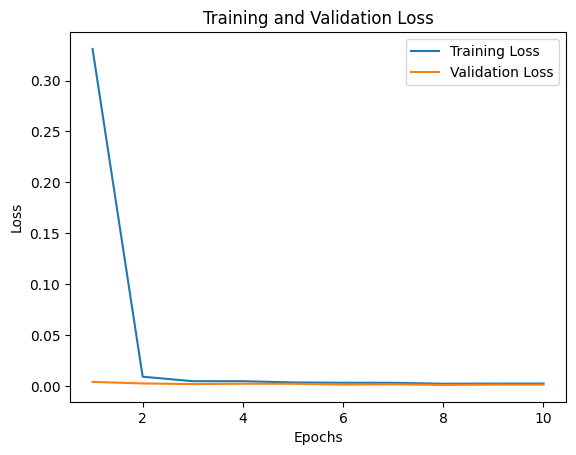


Performance on test dataset after training:
testing model...
Test Loss: 0.0007 - Test Accuracy: 99.95%


In [ ]:
def main():

    random.seed(10)

    parser = argparse.ArgumentParser()
    parser.add_argument('-no_cuda', action='store_true')
    parser.add_argument('-SGDR', action='store_true')
    parser.add_argument('-epochs', type=int, default=10)
    parser.add_argument('-d_model', type=int, default=128)
    parser.add_argument('-d_ff', type=int, default=256)
    parser.add_argument('-n_layers', type=int, default=4)
    parser.add_argument('-heads', type=int, default=4)
    parser.add_argument('-dropout', type=int, default=0.3)
    parser.add_argument('-batchsize', type=int, default=16)
    parser.add_argument('-lr', type=float, default=1e-5)
    parser.add_argument('-max_seqlen', type=int, default=1024)
    parser.add_argument('-savename', type=str, default="transformer_model.pth")

    if "google.colab" in sys.modules:
      sys.argv = ["notebook"]

    opt = parser.parse_args()

    opt.device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")

    print(str(opt))

    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    opt.tokenizer = tokenizer

    real_train, fake_train = read_file('real.train.txt', opt), read_file('fake.train.txt', opt)
    real_valid, fake_valid = read_file('real.valid.txt', opt), read_file('fake.valid.txt', opt)
    real_test, fake_test = read_file('real.test.txt', opt), read_file('fake.test.txt', opt)

    train_dataset = FakeRealDataset(real_train, fake_train)
    valid_dataset = FakeRealDataset(real_valid, fake_valid)
    test_dataset  = FakeRealDataset(real_test,  fake_test)

    opt.train = DataLoader(train_dataset, batch_size=opt.batchsize, shuffle=True, collate_fn=beautify_data)
    opt.valid = DataLoader(valid_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data)
    opt.test  = DataLoader(test_dataset, batch_size=opt.batchsize, shuffle=False, collate_fn=beautify_data)

    opt.vocab_size = 50257

    model = TransformerClassifier(opt.vocab_size,
                                  d_model=opt.d_model,
                                  num_heads=opt.heads,
                                  num_layers=opt.n_layers,
                                  ff_dim=opt.d_ff,
                                  dropout=opt.dropout)

    opt.optimizer = torch.optim.AdamW(model.parameters(), lr=opt.lr)

    print("\nPerformance on train dataset before training:")
    test_model(model, opt, test_dataset = "train")

    print("\nPerformance on validation dataset before training:")
    test_model(model, opt, test_dataset = "valid")

    print("\nPerformance on test dataset before training:")
    test_model(model, opt, test_dataset = "test")

    train(model, opt)

    shutil.copy(os.path.join("./model_weights", opt.savename), cs461dir)

    model_retrieved = TransformerClassifier(opt.vocab_size,
                                            d_model=opt.d_model,
                                            num_heads=opt.heads,
                                            num_layers=opt.n_layers,
                                            ff_dim=opt.d_ff,
                                            dropout=opt.dropout)
    model_retrieved.load_state_dict(torch.load(os.path.join("./model_weights", opt.savename), weights_only = True))

    print("\nPerformance on test dataset after training:")
    test_model(model_retrieved, opt, test_dataset = "test")

if __name__ == "__main__":
    main()